In [6]:
import os
import numpy as np
from PIL import Image

import torch
import torch.utils.data
from torch.optim.lr_scheduler import StepLR
import torchvision as vision
from dataset import PennFudanDataset, get_transform
from model import (
    get_instance_segmentation_model, 
    validate, 
    load_checkpoint, 
    save_checkpoint
)
from dataset import PennFudanDataset, get_transform, get_data
from engine import train_one_epoch, evaluate

import utils

DEBUG = True
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



In [2]:
import main

In [3]:
main.predict_from_file(
    "/home/ubuntu/maskrcnn/PennFudanPed/PNGImages/FudanPed00019.png"
)

/home/ubuntu/venv/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[{'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([]),
  'masks': tensor([], size=(0, 1, 442, 497))}]

In [8]:
in_path = "/home/ubuntu/maskrcnn/PennFudanPed/PNGImages/FudanPed00019.png"
out_path = None 
checkpoint_path = "maskrcnn.ckpt"
boxes = True
masks = True
min_score = 0.5

In [14]:
if not os.path.exists(in_path):
    raise Exception(
        f"file path does not exist: in_path={in_path}"
    )
if not os.path.exists(checkpoint_path):
    raise Exception(
        f"file path does not exist: checkpoint_path={checkpoint_path}"
    )
model = get_instance_segmentation_model(2)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params=params, lr=0.005, momentum=0.9, weight_decay=0.0005)
(
    model_state_dict, optimizer_state_dict, epoch_start, loss_min
) = load_checkpoint(checkpoint_path)
model.load_state_dict(model_state_dict)
optimizer.load_state_dict(optimizer_state_dict)
img = Image.open(in_path).convert("RGB")
to_tensor = vision.transforms.PILToTensor()
tensor = to_tensor(img).to(torch.float)/255
model.eval()
with torch.no_grad():
    preds = model(tensor.unsqueeze(0))
if out_path is None:
    # return preds
    pass
else:
    Vizualizer.save(
        img=tensor,
        filepath=out_path,
        boxes=pred[0]["boxes"][pred[0]["scores"]>threshold,...], 
        masks=pred[0]["masks"][pred[0]["scores"]>threshold,...],
    )

In [38]:
!python3 predict.py --in_path "/home/ubuntu/maskrcnn/PennFudanPed/PNGImages/FudanPed00019.png" --out_path "result1337.png"


/home/ubuntu/venv/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# let's train it for 10 epochs

# num_epochs = 1  # if DEBUG else 10
# checkpoint_path = "maskrcnn.ckpt"
# data_path = "PennFudanPed"

def train(data_path, checkpoint_path="maskrcnn.ckpt", num_epochs = 1, debug=True):
    data_loader, data_loader_test = get_data(path=data_path, debug=debug)
    model = get_instance_segmentation_model(2)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params=params,lr=0.005, momentum=0.9, weight_decay=0.0005)
    if os.path.exists(checkpoint_path):
        (
            model_state_dict, optimizer_state_dict, epoch_start, loss_min
        ) = load_checkpoint(checkpoint_path)
        model.load_state_dict(model_state_dict)
        optimizer.load_state_dict(optimizer_state_dict)
    else:
        epoch_start = 0
        loss_min = None
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(epoch_start, num_epochs):
        # train for one epoch, printing every 10 iterations
        metric_logger = train_one_epoch(
            model, optimizer, data_loader, DEVICE, epoch,
            print_freq=2 if DEBUG else 10,
        )
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        loss = validate(model, optimizer, data_loader_test, DEVICE)
        print(f"loss_val={loss}")
        if loss_min is None or loss < loss_min:
            save_checkpoint(model, optimizer, checkpoint_path, epoch, loss)
            loss_min = loss
        evaluator = evaluate(
            model,
            data_loader_test,
            device=DEVICE
        )


In [24]:
# data_path = "PennFudanPed"
# train(
#     data_path=data_path, 
#     checkpoint_path="maskrcnn.ckpt", 
#     num_epochs=1, 
#     debug=True
# )


In [43]:
def predict_from_file(
    in_path: str, 
    out_path=None, 
    checkpoint_path: str = "maskrcnn.ckpt", 
    boxes: bool = True, 
    masks: bool = True,
    min_score: float = 0.5
):
    if not os.path.exists(in_path):
        raise Exception(
            f"file path does not exist: in_path={in_path}"
        )
    # if not os.path.exists(out_path):
    #     raise Exception(
    #         f"file path does not exist: out_path={out_path}"
    #     )
    if not os.path.exists(checkpoint_path):
        raise Exception(
            f"file path does not exist: checkpoint_path={checkpoint_path}"
        )
    model = get_instance_segmentation_model(2)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params=params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    (
        model_state_dict, optimizer_state_dict, epoch_start, loss_min
    ) = load_checkpoint(checkpoint_path)
    model.load_state_dict(model_state_dict)
    optimizer.load_state_dict(optimizer_state_dict)
    img = Image.open(in_path).convert("RGB")
    to_tensor = vision.transforms.PILToTensor()
    tensor = to_tensor(img)
    model.eval()
    with torch.no_grad():
        preds = model(tensor.unsqueeze(0).to(torch.float)/255)
    if out_path is None:
        return preds

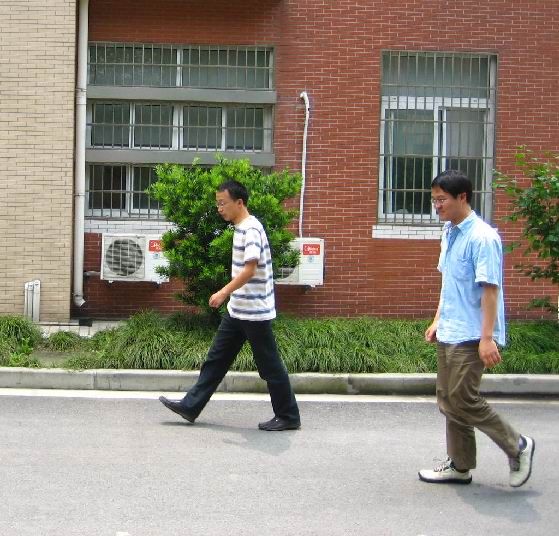

In [61]:
img


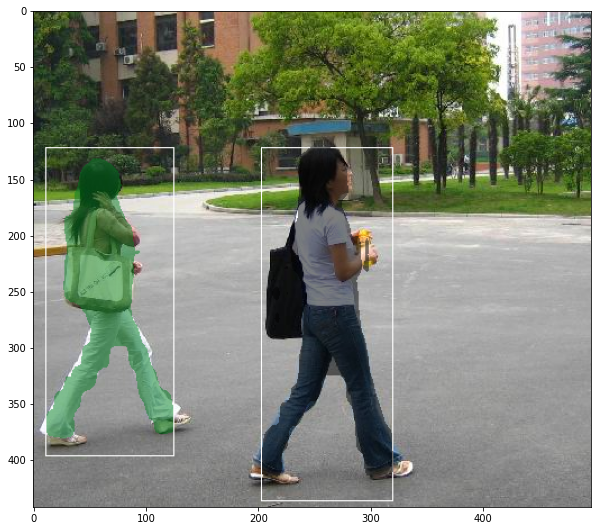

In [81]:
# from visualizer import Vizualizer
min_score = 0.5
fpath = "/home/ubuntu/maskrcnn/PennFudanPed/PNGImages/FudanPed00019.png"

img = Image.open(fpath).convert("RGB")
pred = predict_from_file(fpath)
to_tensor = vision.transforms.PILToTensor()
tensor = to_tensor(img).to(torch.float)/255
Vizualizer.show(
    img=tensor, 
    boxes=pred[0]["boxes"][pred[0]["scores"]>.5,...], 
    masks=pred[0]["masks"][pred[0]["scores"]>.5,...],
    
)

In [84]:
import cv2
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms.functional import to_tensor
from matplotlib import pyplot as plt
from copy import deepcopy


class Vizualizer:
    @staticmethod
    def add_boxes(img, boxes):        
        img_bbox = draw_bounding_boxes(
            image=img,
            boxes=boxes
        )
        return img_bbox

    @staticmethod
    def add_masks(img, masks):
        img_mask = draw_segmentation_masks(
            image=img,
            masks=masks.squeeze().round().to(torch.bool),
            alpha=0.5
        )
        return img_mask

    @classmethod
    def save(cls, img, filepath, boxes=None, masks=None):
        # img = deepcopy(img)
        img = (deepcopy(img) * 255).to(torch.uint8)
        if boxes is not None: img = cls.add_boxes(img, boxes)
        if masks is not None: img = cls.add_masks(img, masks)
        cv2.imwrite(filename=filepath, img=img.permute(1,2,0).numpy())

    @classmethod
    def show(cls, img, boxes=None, masks=None):
        img = (deepcopy(img) * 255).to(torch.uint8)
        if boxes is not None: img = cls.add_boxes(img, boxes)
        if masks is not None: img = cls.add_masks(img, masks)
        plt.figure(figsize = (10,10))
        plt.imshow(img.permute(1,2,0))


In [85]:
Vizualizer.save(
    img=tensor,
    filepath="result.png",
    boxes=pred[0]["boxes"][pred[0]["scores"]>.5,...], 
    masks=pred[0]["masks"][pred[0]["scores"]>.5,...],
    
)
